In [1]:
!pip install opencv-python

   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB 145.2 kB/s eta 0:04:26
   ---------------------------------------- 0.0/38.6 MB 145.2 kB/s eta 0:04:26
   ---------------------------------------- 0.0/38.6 MB 145.2 kB/s eta 0:04:26
   ---------------------------------------- 0.1/38.6 MB 182.2 kB/s eta 0:03:32
   ---------------------------------------- 0.1/38.6 MB 208.4 kB/s eta 0:03:05
   ---------------------------------------- 0.1/38.6 MB 218.5 kB/s eta 0:02:57
   ---------------------------------------- 0.1/38.6 MB 252.2 kB/s eta 0:02:33
   ------------------------

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2 
import os

In [3]:
import os
import cv2
import numpy as np

def load_dataset(path_dataset, target_size=(125, 125)): 
    dataset = []
    labels = []

    # Iterate over all folders in dataset_path
    for label in os.listdir(path_dataset):
        class_path = os.path.join(path_dataset, label)

        # check if the directory exists
        if os.path.isdir(class_path):
            # Initialize a counter for images in each class
            images_counter = 0
            
            # Iterate over all images in folder/class
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)

                # Load image with OpenCV
                image = cv2.imread(image_path)

                # Check if the image was loaded successfully
                if image is not None:
                    # Resize the image
                    image = cv2.resize(image, target_size)

                    # Add image and label to dataset
                    dataset.append(image)
                    labels.append(label)


                else:
                    print(f"Error loading image: {image_path}")

    return np.array(dataset), np.array(labels)

dataset_path = "./archive"
dataset, labels = load_dataset(dataset_path) 

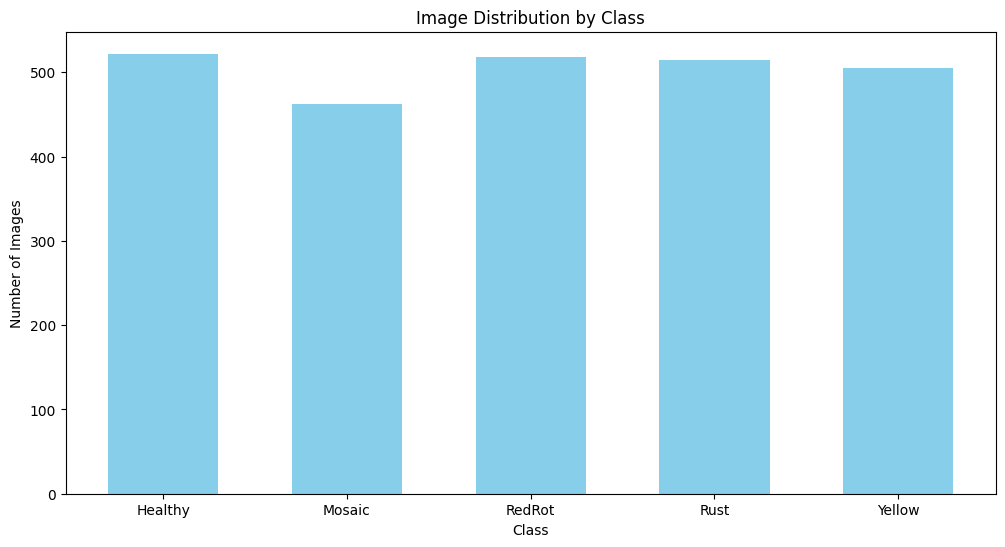

In [4]:
unique_labels, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(unique_labels, counts))

fig, ax = plt.subplots(figsize=(12, 6)) 
bars = ax.bar(class_counts.keys(), class_counts.values(), color='skyblue', width=0.6)  

ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Image Distribution by Class')

plt.show()

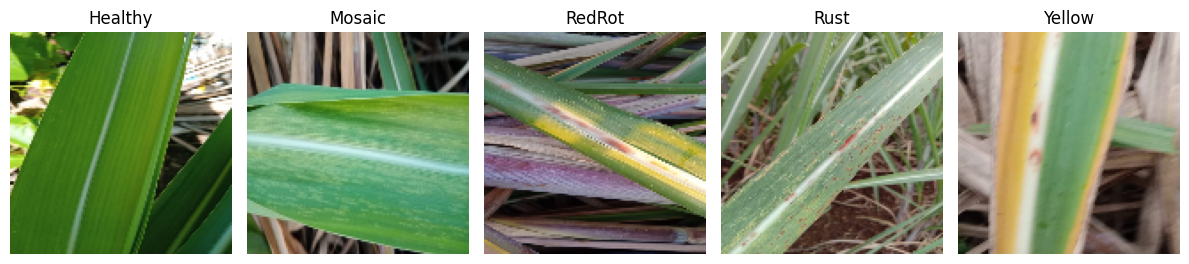

In [5]:
import random
import matplotlib.pyplot as plt

def show_samples(dataset, labels, classes, num_samples):
    plt.figure(figsize=(12, 6))
    
    for i, class_name in enumerate(classes[:num_samples]):  # Show only the first num_samples classes
        indices_class = np.where(labels == class_name)[0]
        sample_index = random.choice(indices_class)
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(dataset[sample_index], cv2.COLOR_BGR2RGB))
        plt.title(f'{class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


unique_classes = np.unique(labels)
show_samples(dataset, labels, unique_classes, num_samples=5)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels into numbers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(dataset, encoded_labels, test_size=0.2, random_state=42)


def preprocess_image(image):
    resized_image = cv2.resize(image, (125, 125))
    
    #Normalize values between 0 and 1
    normalized_image = resized_image / 255.0
    return normalized_image

# Apply preprocessing to training and testing sets
X_train = np.array([preprocess_image(image) for image in X_train])
X_test = np.array([preprocess_image(image) for image in X_test])

# Check the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2016, 125, 125, 3)
Shape of X_test: (505, 125, 125, 3)
Shape of y_train: (2016,)
Shape of y_test: (505,)


In [7]:
!pip install efficientnet

In [17]:
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np


num_classes = len(np.unique(labels))

model = models.Sequential()

efficientnet_model = EfficientNetB0(input_shape=(125, 125, 3), include_top=False, weights='imagenet', pooling='max')
# Assume efficientnet_model is already defined
# Set the layers you want to fine-tune
layers_to_unfreeze = 20  # Example: Unfreeze the last 10 layers

# Unfreeze the specified layers
for layer in efficientnet_model.layers[-layers_to_unfreeze:]:
    layer.trainable = True
for layer in efficientnet_model.layers[:layers_to_unfreeze]:
    layer.trainable = True


model.add(efficientnet_model)

model.add(Dense(128, kernel_regularizer=l1(0.0001), activation='relu'))
model.add(BatchNormalization(renorm=True))
model.add(Dropout(0.3))

model.add(Dense(64, kernel_regularizer=l1(0.0001), activation='relu'))
model.add(BatchNormalization(renorm=True))
model.add(Dropout(0.3))

model.add(Dense(32, kernel_regularizer=l1(0.0001), activation='relu'))
model.add(BatchNormalization(renorm=True))
model.add(Dropout(0.3))

model.add(Dense(units=num_classes, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

custom_optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/150
63/63 [==============================] - 80s 978ms/step - loss: 3.2341 - accuracy: 0.2133 - val_loss: 2.3290 - val_accuracy: 0.2099
Epoch 2/150
63/63 [==============================] - 58s 921ms/step - loss: 2.4651 - accuracy: 0.3051 - val_loss: 2.1993 - val_accuracy: 0.3030
Epoch 3/150
63/63 [==============================] - 56s 889ms/step - loss: 2.2409 - accuracy: 0.3904 - val_loss: 2.0178 - val_accuracy: 0.4356
Epoch 4/150
63/63 [==============================] - 56s 888ms/step - loss: 2.0759 - accuracy: 0.4598 - val_loss: 1.8419 - val_accuracy: 0.5347
Epoch 5/150
63/63 [==============================] - 56s 892ms/step - loss: 1.8485 - accuracy: 0.5407 - val_loss: 1.6657 - val_accuracy: 0.5921
Epoch 6/150
63/63 [==============================] - 57s 902ms/step - loss: 1.7200 - accuracy: 0.5928 - val_loss: 1.5367 - val_accuracy: 0.6653
Epoch 7/150
63/63 [==============================] - 57s 898ms/step - loss: 1.5761 - accuracy: 0.6622 - val_loss: 1.4306 - val_accuracy:

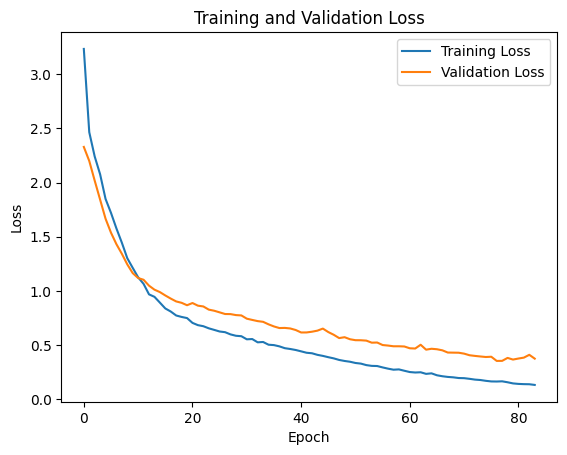

In [18]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

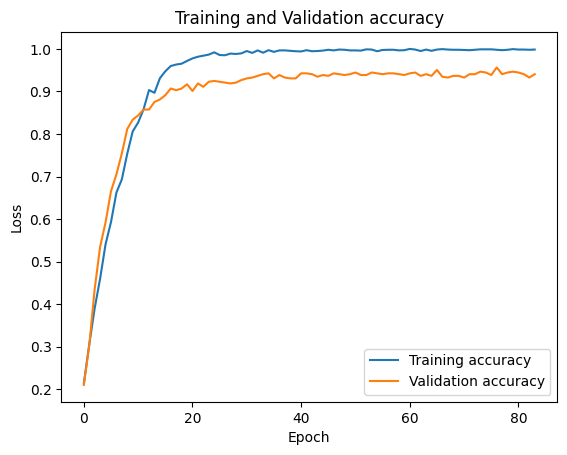

In [20]:
# Plot training and validation loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Predict class probabilities
y_pred_prob = model.predict(X_test)
y_pred = tf.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = y_test

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

16/16 [==============================] - 5s 160ms/step
Accuracy: 0.9564356435643564
Precision: 0.9573174336597211
Recall: 0.9564356435643564
F1-score: 0.95637997842305


Confusion Matrix:
[[100   3   1   0   0]
 [  1  80   1   1   0]
 [  0   0 103   0   0]
 [  3   3   1 109   1]
 [  0   1   3   3  91]]


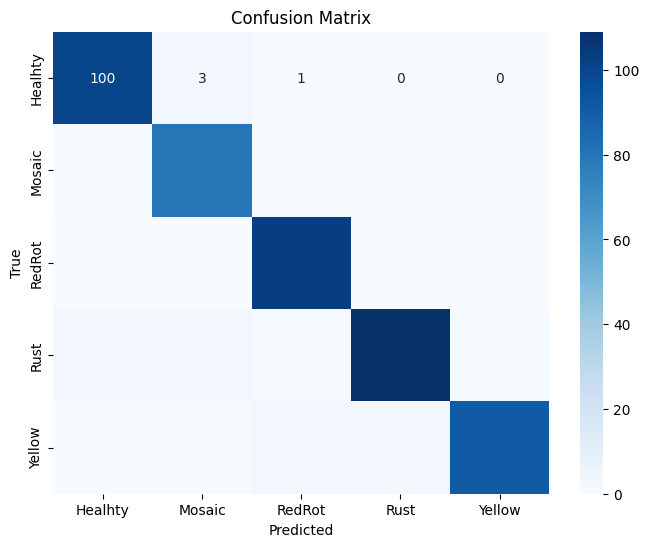

In [22]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming y_true and y_pred are your true and predicted labels respectively
# y_true and y_pred should be numpy arrays or lists

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# If you want to visualize the confusion matrix, you can use seaborn or matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Define labels for the confusion matrix
labels = ['Healhty', 'Mosaic', 'RedRot','Rust','Yellow']  # Replace with your actual class labels

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


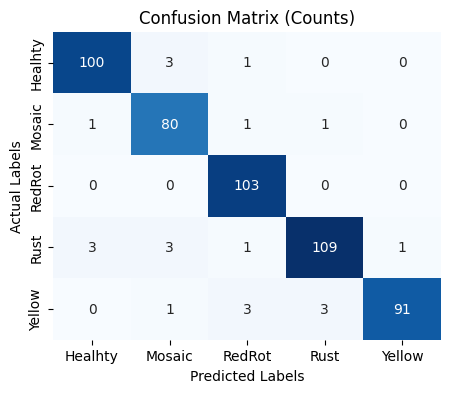

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Your confusion matrix (replace with your actual values)
confusion_matrix = np.array([[100, 3, 1, 0, 0],
                             [1, 80, 1, 1, 0],
                             [0, 0, 103, 0, 0],
                             [3, 3, 1, 109, 1],
                             [0, 1, 3, 3, 91]])

# Create a heatmap
plt.figure(figsize=(5, 4))
labels = ['Healhty', 'Mosaic', 'RedRot','Rust','Yellow']  # Replace with your actual class labels
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",xticklabels=labels, yticklabels=labels, cbar=False)

# Customize the plot
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")

# Show the plot
plt.show()



In [23]:
# Save the model in the native Keras format
model.save('SugarcaneLeaf2.keras')